In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from exog
recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

def check_stationarity(series, series_name):
    """Test for stationarity using ADF test"""
    result = adfuller(series.dropna())
    print(f'\n{series_name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is non-stationary")
        return False

def prepare_exog_data(train_df, test_df, target_indicator):
    """Prepare exogenous variables"""
    print(f"\nPreparing exogenous variables for {target_indicator}...")
    features_to_exclude = ['date'] + recession_targets + [target_indicator]
    available_features = [c for c in train_df.columns if c not in features_to_exclude]
    print(f"Available exogenous features: {len(available_features)}")
    print(f"Features: {available_features[:10]}..." if len(available_features) > 10 else f"Features: {available_features}")
    return train_df[available_features].copy(), test_df[available_features].copy(), available_features

def clean_exog_data(train_exog, test_exog):
    """Clean exogenous data"""
    print(f"Cleaning exogenous data...")
    print(f"  Initial shapes - Train: {train_exog.shape}, Test: {test_exog.shape}")
    train_exog = train_exog.fillna(method='ffill').fillna(method='bfill')
    test_exog = test_exog.fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
    test_exog = test_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
    varying_cols = [c for c in train_exog.columns if train_exog[c].nunique() > 1]
    train_exog = train_exog[varying_cols]
    test_exog = test_exog[varying_cols]
    test_exog = test_exog[train_exog.columns]
    print(f"  Final shapes - Train: {train_exog.shape}, Test: {test_exog.shape}")
    print(f"  Remaining missing values - Train: {train_exog.isnull().sum().sum()}, Test: {test_exog.isnull().sum().sum()}")
    return train_exog, test_exog

def auto_arima_with_exog(series, exog, max_p=3, max_d=2, max_q=3, verbose=True):
    """Grid search for best ARIMA parameters"""
    best_aic = float('inf')
    best_order = None
    best_model = None
    tried_orders = []

    print(f"\nRunning ARIMA grid search...")
    print(f"Series length: {len(series)}, Exog shape: {exog.shape}")

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    if verbose:
                        print(f"  Trying ARIMA order: ({p},{d},{q})")
                    model = ARIMA(series, order=(p, d, q), exog=exog)
                    fitted = model.fit()
                    if verbose:
                        print(f"    Success: AIC = {fitted.aic:.2f}")
                    if fitted.aic < best_aic:
                        best_aic, best_order, best_model = fitted.aic, (p, d, q), fitted
                    tried_orders.append((p, d, q, fitted.aic))
                except Exception as e:
                    if verbose:
                        print(f"    Failed ARIMA({p},{d},{q}): {str(e)[:100]}")
                    continue

    print(f"\nBest model found: ARIMA{best_order} with AIC = {best_aic:.2f}")
    print(f"Total successful fits: {len(tried_orders)}")
    return best_model, best_order, best_aic

def create_residual_features(residuals, exog_features, lag_periods=5):
    """Create features for XGBoost from ARIMA residuals and exogenous data"""
    feature_dict = {}
    
    # Lag features from residuals
    for lag in range(1, lag_periods + 1):
        feature_dict[f'residual_lag_{lag}'] = np.concatenate([[np.nan] * lag, residuals[:-lag]])
    
    # Moving average of residuals
    for window in [3, 5]:
        feature_dict[f'residual_ma_{window}'] = pd.Series(residuals).rolling(window=window, min_periods=1).mean().values
    
    # Add exogenous features with lags
    for col in exog_features.columns:
        feature_dict[col] = exog_features[col].values
        
        # Add lag features for exogenous variables
        for lag in range(1, 3):
            feature_dict[f'{col}_lag_{lag}'] = np.concatenate([[np.nan] * lag, exog_features[col].values[:-lag]])
    
    return pd.DataFrame(feature_dict)

def make_xgboost_objective(X_train, y_train, X_val, y_val):
    """Create Optuna objective for XGBoost hyperparameter tuning"""
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5.0, log=True),
        }
        
        try:
            model = xgb.XGBRegressor(**params, random_state=42, verbosity=0)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            
            y_pred = model.predict(X_val)
            rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
            
            return rmse
            
        except Exception as e:
            print(f"XGBoost trial failed: {e}")
            return float('inf')
    
    return objective

def hybrid_forecast_indicator_arima(train_df, test_df, indicator, 
                                    max_p=3, max_d=2, max_q=3, n_trials_xgb=20):
    """Hybrid forecast using ARIMA + XGBoost"""
    print(f"\n{'='*60}\nHYBRID FORECASTING: {indicator}\n{'='*60}")
    
    if indicator not in train_df.columns or indicator not in test_df.columns:
        print(f"ERROR: {indicator} not in datasets")
        return None
    
    train_series = train_df[indicator].dropna()
    test_series = test_df[indicator].dropna()
    print(f"Series lengths - Train: {len(train_series)}, Test: {len(test_series)}")
    
    if len(train_series) < 10:
        print(f"ERROR: Insufficient training data for {indicator}")
        return None
    
    # Step 1: Prepare exogenous features
    print("\n--- STEP 1: Preparing Exogenous Variables ---")
    try:
        train_exog, test_exog, exog_features = prepare_exog_data(train_df, test_df, indicator)
        train_exog = train_exog.loc[train_series.index]
        test_exog = test_exog.loc[test_series.index]
        train_exog, test_exog = clean_exog_data(train_exog, test_exog)
        
        if train_exog.shape[1] == 0:
            print(f"WARNING: No exogenous variables for {indicator}")
            return None
    except Exception as e:
        print(f"ERROR preparing exogenous: {e}")
        return None
    
    # Step 2: Check stationarity and train ARIMA
    print("\n--- STEP 2: Training ARIMA Model ---")
    is_stationary = check_stationarity(train_series, indicator)
    
    try:
        arima_model, order, aic = auto_arima_with_exog(train_series, train_exog, max_p, max_d, max_q)
        
        if arima_model is None:
            print(f"ERROR: No ARIMA model for {indicator}")
            return None
        
        # Get ARIMA predictions on train data for residual learning
        train_arima_pred = arima_model.fittedvalues
        train_residuals = train_series.values - train_arima_pred.values
        
        # Forecast on test set
        steps = min(len(test_series), len(test_exog))
        print(f"  Forecasting {steps} steps ahead")
        arima_forecast = arima_model.forecast(steps=steps, exog=test_exog.iloc[:steps])
        
        print(f"ARIMA MAE: {np.mean(np.abs(test_series.iloc[:steps].values - arima_forecast.values)):.4f}")
        
    except Exception as e:
        print(f"ERROR training ARIMA for {indicator}: {e}")
        return None
    
    # Step 3: Train XGBoost on residuals
    print("\n--- STEP 3: Training XGBoost on Residuals ---")
    try:
        # Create features for XGBoost
        xgb_features = create_residual_features(train_residuals, train_exog, lag_periods=5)
        
        # Remove NaN rows
        valid_idx = ~xgb_features.isnull().any(axis=1)
        X_train_xgb = xgb_features[valid_idx].values
        y_train_xgb = train_residuals[valid_idx]
        
        if len(X_train_xgb) < 10:
            print("WARNING: Insufficient samples for XGBoost, using ARIMA only")
            xgb_model = None
            best_xgb_params = None
        else:
            # Split for validation
            split_idx = int(0.8 * len(X_train_xgb))
            X_train_xgb_split = X_train_xgb[:split_idx]
            y_train_xgb_split = y_train_xgb[:split_idx]
            X_val_xgb = X_train_xgb[split_idx:]
            y_val_xgb = y_train_xgb[split_idx:]
            
            # Hyperparameter tuning
            print(f"Tuning XGBoost with {n_trials_xgb} trials...")
            study_xgb = optuna.create_study(direction="minimize")
            study_xgb.optimize(
                make_xgboost_objective(X_train_xgb_split, y_train_xgb_split, X_val_xgb, y_val_xgb),
                n_trials=n_trials_xgb,
                show_progress_bar=False
            )
            
            best_xgb_params = study_xgb.best_params
            print(f"Best XGBoost params: {best_xgb_params}")
            
            # Train final XGBoost model
            xgb_model = xgb.XGBRegressor(**best_xgb_params, random_state=42, verbosity=0)
            xgb_model.fit(X_train_xgb, y_train_xgb)
            
            residual_pred_train = xgb_model.predict(X_train_xgb)
            print(f"XGBoost Residual MAE: {np.mean(np.abs(y_train_xgb - residual_pred_train)):.4f}")
    
    except Exception as e:
        print(f"WARNING: Could not train XGBoost: {e}")
        xgb_model = None
        best_xgb_params = None
    
    # Step 4: Make hybrid predictions on test set
    print("\n--- STEP 4: Making Hybrid Predictions ---")
    try:
        arima_pred_test = arima_forecast.values
        
        if xgb_model is not None:
            # Create test features
            test_residuals_placeholder = np.zeros(len(test_exog))
            xgb_features_test = create_residual_features(test_residuals_placeholder, test_exog.iloc[:steps], lag_periods=5)
            X_test_xgb = xgb_features_test.values
            
            # Predict residuals and combine
            residual_pred_test = xgb_model.predict(X_test_xgb)
            hybrid_pred_test = arima_pred_test + residual_pred_test
        else:
            hybrid_pred_test = arima_pred_test
            residual_pred_test = np.zeros_like(arima_pred_test)
        
        # Calculate metrics
        y_true_test = test_series.iloc[:steps].values
        
        arima_mae = np.mean(np.abs(y_true_test - arima_pred_test))
        arima_rmse = np.sqrt(np.mean((y_true_test - arima_pred_test) ** 2))
        
        hybrid_mae = np.mean(np.abs(y_true_test - hybrid_pred_test))
        hybrid_rmse = np.sqrt(np.mean((y_true_test - hybrid_pred_test) ** 2))
        
        # MAPE
        mask = y_true_test != 0
        arima_mape = np.mean(np.abs((y_true_test[mask] - arima_pred_test[mask]) / y_true_test[mask])) * 100 if mask.any() else np.inf
        hybrid_mape = np.mean(np.abs((y_true_test[mask] - hybrid_pred_test[mask]) / y_true_test[mask])) * 100 if mask.any() else np.inf
        
        improvement = ((arima_mae - hybrid_mae) / arima_mae * 100) if arima_mae > 0 else 0
        
        print(f"\nTest Metrics:")
        print(f"  ARIMA   - MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")
        print(f"  Hybrid  - MAE: {hybrid_mae:.4f}, RMSE: {hybrid_rmse:.4f}, MAPE: {hybrid_mape:.2f}%")
        print(f"  Improvement: {improvement:.2f}%")
        
        # Save models
        os.makedirs("hybrid_arima_models", exist_ok=True)
        with open(f"hybrid_arima_models/{indicator}_arima_model.pkl", "wb") as f:
            pickle.dump(arima_model, f)
        if xgb_model is not None:
            with open(f"hybrid_arima_models/{indicator}_xgboost_model.pkl", "wb") as f:
                pickle.dump(xgb_model, f)
        
        return {
            'arima_model': arima_model,
            'xgb_model': xgb_model,
            'arima_order': order,
            'arima_aic': aic,
            'xgb_params': best_xgb_params,
            'arima_forecast': arima_pred_test,
            'residual_forecast': residual_pred_test,
            'hybrid_forecast': hybrid_pred_test,
            'actual': y_true_test,
            'arima_mae': arima_mae,
            'arima_rmse': arima_rmse,
            'arima_mape': arima_mape,
            'hybrid_mae': hybrid_mae,
            'hybrid_rmse': hybrid_rmse,
            'hybrid_mape': hybrid_mape,
            'improvement': improvement,
            'exog_features': train_exog.columns.tolist(),
            'is_stationary': is_stationary,
            'test_dates': test_df.loc[test_series.index, 'date'].iloc[:steps].values
        }
        
    except Exception as e:
        print(f"ERROR making predictions: {e}")
        return None

def plot_hybrid_forecast_results_arima(results, indicator):
    """Plot hybrid forecast results with comparison"""
    if results is None:
        return
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    test_dates = pd.to_datetime(results['test_dates'])
    actual = results['actual']
    arima_pred = results['arima_forecast']
    hybrid_pred = results['hybrid_forecast']
    
    # Plot 1: Actual vs Predictions
    ax = axes[0]
    ax.plot(test_dates, actual, label='Actual', color='green', linewidth=2.5, marker='o', markersize=5)
    ax.plot(test_dates, arima_pred, label='ARIMA Only', color='orange', linewidth=2, marker='s', markersize=4, alpha=0.8)
    ax.plot(test_dates, hybrid_pred, label='Hybrid (ARIMA+XGBoost)', color='red', linewidth=2, marker='^', markersize=4, alpha=0.8)
    
    ax.set_title(f'{indicator} - Forecast Comparison', fontsize=13, fontweight='bold')
    ax.set_ylabel('Value')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Plot 2: Errors comparison
    ax = axes[1]
    arima_errors = np.abs(actual - arima_pred)
    hybrid_errors = np.abs(actual - hybrid_pred)
    
    ax.plot(test_dates, arima_errors, label='ARIMA Error', color='orange', linewidth=2, marker='s', markersize=4, alpha=0.8)
    ax.plot(test_dates, hybrid_errors, label='Hybrid Error', color='red', linewidth=2, marker='^', markersize=4, alpha=0.8)
    ax.fill_between(test_dates, arima_errors, hybrid_errors, where=(arima_errors >= hybrid_errors), 
                     alpha=0.2, color='green', label='Hybrid Improvement')
    ax.fill_between(test_dates, arima_errors, hybrid_errors, where=(arima_errors < hybrid_errors), 
                     alpha=0.2, color='red', label='ARIMA Better')
    
    ax.set_title('Absolute Errors Comparison', fontsize=13, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Absolute Error')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Summary text
    summary = (f"ARIMA{results['arima_order']} - MAE: {results['arima_mae']:.4f}, RMSE: {results['arima_rmse']:.4f}\n"
              f"Hybrid  - MAE: {results['hybrid_mae']:.4f}, RMSE: {results['hybrid_rmse']:.4f}\n"
              f"Improvement: {results['improvement']:.2f}% | Stationary: {results['is_stationary']}")
    fig.text(0.5, -0.02, summary, ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    plt.show()

def run_hybrid_arima_forecasting(train_df, test_df, financial_indicators=None, 
                                 max_p=3, max_d=2, max_q=3, n_trials_xgb=20, plot_results=True):
    """Run hybrid ARIMA + XGBoost forecasting pipeline"""
    print("=" * 80)
    print("HYBRID FORECASTING - ARIMA + XGBOOST")
    print("=" * 80)
    
    if financial_indicators is None:
        financial_indicators = [
            '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
            '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
            'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
        ]
    
    train_work = train_df.copy()
    test_work = test_df.copy()
    train_work['date'] = pd.to_datetime(train_work['date'])
    test_work['date'] = pd.to_datetime(test_work['date'])
    
    available = [i for i in financial_indicators if i in train_work.columns and i in test_work.columns]
    print(f"Indicators to forecast: {available}")
    
    all_results = {}
    forecasted = pd.DataFrame({'date': test_work['date'].copy()})
    
    for ind in available:
        res = hybrid_forecast_indicator_arima(
            train_work, test_work, ind,
            max_p=max_p, max_d=max_d, max_q=max_q,
            n_trials_xgb=n_trials_xgb
        )
        
        if res:
            all_results[ind] = res
            
            forecasted[f'{ind}_arima'] = np.nan
            forecasted[f'{ind}_hybrid'] = np.nan
            forecasted[f'{ind}_actual'] = np.nan
            
            steps = len(res['actual'])
            forecasted.iloc[:steps, forecasted.columns.get_loc(f'{ind}_arima')] = res['arima_forecast']
            forecasted.iloc[:steps, forecasted.columns.get_loc(f'{ind}_hybrid')] = res['hybrid_forecast']
            forecasted.iloc[:steps, forecasted.columns.get_loc(f'{ind}_actual')] = res['actual']
            
            if plot_results:
                plot_hybrid_forecast_results_arima(res, ind)
    
    print(f"\n{'='*60}")
    print("HYBRID ARIMA FORECASTING COMPLETE")
    print(f"{'='*60}")
    print(f"Successfully forecasted {len(all_results)} indicators\n")
    
    # Summary metrics table
    if all_results:
        print("SUMMARY METRICS:")
        print(f"{'Indicator':<20} {'ARIMA Order':<15} {'ARIMA MAE':<12} {'Hybrid MAE':<12} {'Improvement':<12} {'XGBoost Used':<12}")
        print("-" * 83)
        for ind, res in all_results.items():
            xgb_used = "Yes" if res['xgb_model'] is not None else "No"
            print(f"{ind:<20} {str(res['arima_order']):<15} {res['arima_mae']:<12.4f} {res['hybrid_mae']:<12.4f} {res['improvement']:<12.2f}% {xgb_used:<12}")
    
    return all_results, forecasted

HYBRID FORECASTING - ARIMA + XGBOOST
Indicators to forecast: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index', 'gdp_per_capita']

HYBRID FORECASTING: 1_year_rate
Series lengths - Train: 556, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for 1_year_rate...
Available exogenous features: 29
Features: ['3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (556, 29), Test: (65, 29)
  Final shapes - Train: (556, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

1_year_rate Stationarity Test:
ADF Statistic: -1.464638
p-value: 0.550926
Series is non-stationary

Running ARIMA grid search...
Series length: 556, Exog shape: (556, 29)
  Trying ARIMA order: 

[I 2025-10-12 18:19:10,574] A new study created in memory with name: no-name-897fb028-2442-4add-bd59-45c747eb489a


    Success: AIC = -1896.99

Best model found: ARIMA(3, 0, 0) with AIC = -2252.81
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 0.2412

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 18:19:10,940] Trial 0 finished with value: 0.01040387261455705 and parameters: {'max_depth': 4, 'learning_rate': 0.01919407872147388, 'n_estimators': 96, 'subsample': 0.8958318807876366, 'colsample_bytree': 0.8922980689972277, 'reg_lambda': 0.11983525069352868, 'reg_alpha': 0.14179668842035234}. Best is trial 0 with value: 0.01040387261455705.
[I 2025-10-12 18:19:11,134] Trial 1 finished with value: 0.01310832964406579 and parameters: {'max_depth': 3, 'learning_rate': 0.05167506574486765, 'n_estimators': 157, 'subsample': 0.9177245385114239, 'colsample_bytree': 0.978353068317608, 'reg_lambda': 0.21659642128803558, 'reg_alpha': 1.661501351016222}. Best is trial 0 with value: 0.01040387261455705.
[I 2025-10-12 18:19:11,325] Trial 2 finished with value: 0.012516751923278668 and parameters: {'max_depth': 3, 'learning_rate': 0.23815411511502413, 'n_estimators': 238, 'subsample': 0.6487844313603165, 'colsample_bytree': 0.7404079893310527, 'reg_lambda': 0.31986363350074754, 'reg

Best XGBoost params: {'max_depth': 5, 'learning_rate': 0.11518103366750507, 'n_estimators': 212, 'subsample': 0.875500822018536, 'colsample_bytree': 0.9280875211423955, 'reg_lambda': 1.7807375027808616, 'reg_alpha': 0.23631035016452157}
XGBoost Residual MAE: 0.0048

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 0.2412, RMSE: 0.2765, MAPE: 34.38%
  Hybrid  - MAE: 0.2383, RMSE: 0.2739, MAPE: 33.60%
  Improvement: 1.22%


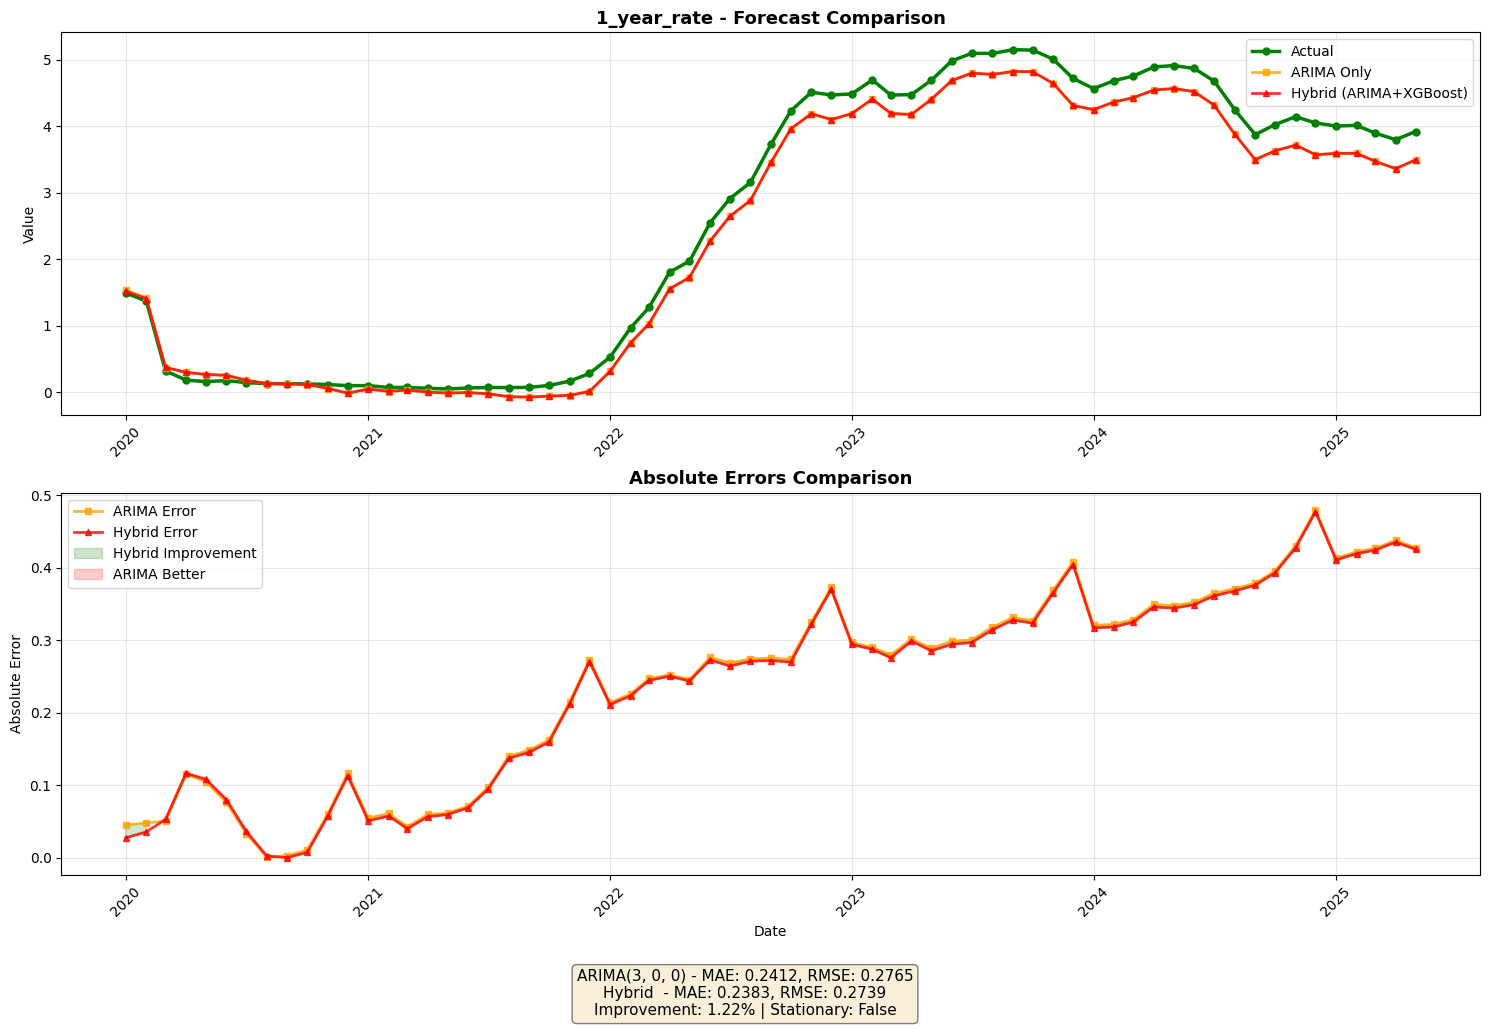


HYBRID FORECASTING: 3_months_rate
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for 3_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

3_months_rate Stationarity Test:
ADF Statistic: -1.869398
p-value: 0.346591
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 1344.09
  Trying ARIMA order: (0,0,1)
    Success: AIC = -2309.07
  Trying ARIMA order: (0,0,2)
    Success: AIC = -2453.28
  Trying ARIMA order: (0,0,3)
    Success: AIC = -2318.43
  Trying ARIMA order: (

[I 2025-10-12 18:35:26,059] A new study created in memory with name: no-name-66d32313-4836-4fbd-ae07-da2b29db6dae


    Success: AIC = -2224.17

Best model found: ARIMA(3, 0, 0) with AIC = -2570.29
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 0.3939

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 18:35:26,298] Trial 0 finished with value: 0.00998871908553748 and parameters: {'max_depth': 3, 'learning_rate': 0.09200994934491451, 'n_estimators': 78, 'subsample': 0.8464366406981761, 'colsample_bytree': 0.6999299324640597, 'reg_lambda': 0.8097272220151995, 'reg_alpha': 0.36956442021967045}. Best is trial 0 with value: 0.00998871908553748.
[I 2025-10-12 18:35:26,604] Trial 1 finished with value: 0.013901873202945956 and parameters: {'max_depth': 5, 'learning_rate': 0.037765144483808924, 'n_estimators': 116, 'subsample': 0.9472625514058689, 'colsample_bytree': 0.67234106433101, 'reg_lambda': 2.1148863467727534, 'reg_alpha': 0.6977743317004912}. Best is trial 0 with value: 0.00998871908553748.
[I 2025-10-12 18:35:26,827] Trial 2 finished with value: 0.014671819170130837 and parameters: {'max_depth': 6, 'learning_rate': 0.014302134817609828, 'n_estimators': 67, 'subsample': 0.900019911371492, 'colsample_bytree': 0.729540851559556, 'reg_lambda': 2.5591758048721416, 'reg_al

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.03371312881378831, 'n_estimators': 256, 'subsample': 0.8246046617647685, 'colsample_bytree': 0.8569497268673552, 'reg_lambda': 1.367564128073107, 'reg_alpha': 0.20662004576412005}
XGBoost Residual MAE: 0.0058

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 0.3939, RMSE: 0.4376, MAPE: 143.74%
  Hybrid  - MAE: 0.3925, RMSE: 0.4371, MAPE: 142.99%
  Improvement: 0.34%


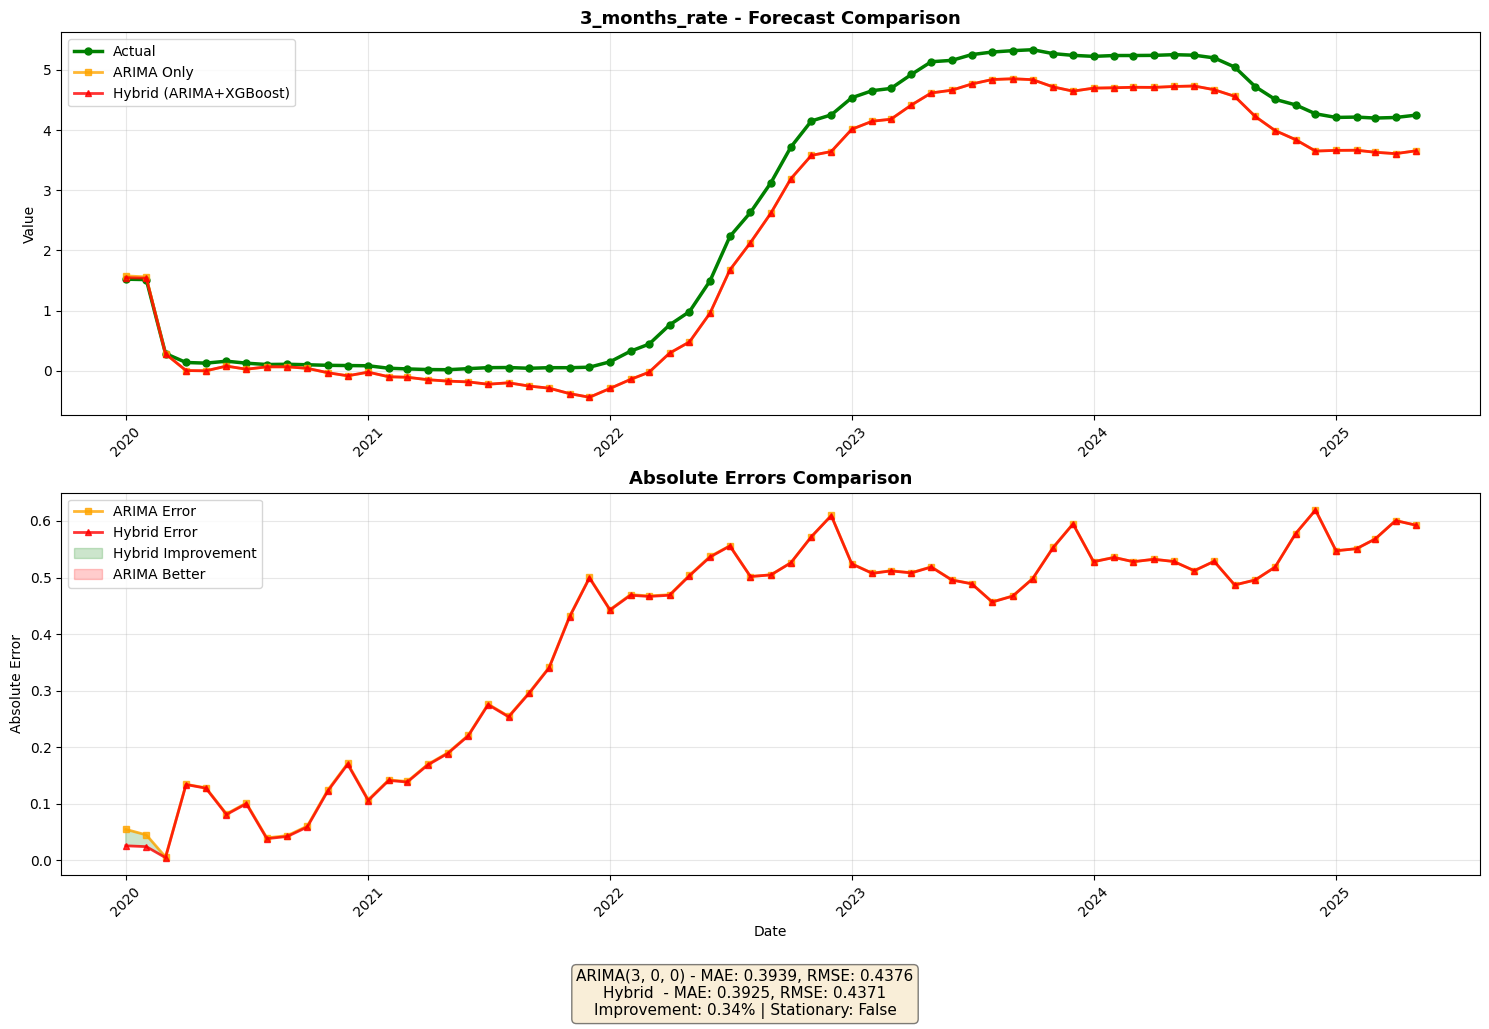


HYBRID FORECASTING: 6_months_rate
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for 6_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

6_months_rate Stationarity Test:
ADF Statistic: -1.740531
p-value: 0.410360
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 723.70
  Trying ARIMA order: (0,0,1)
    Success: AIC = -2897.35
  Trying ARIMA order: (0,0,2)
    Success: AIC = -3065.09
  Trying ARIMA order: (0,0,3)
    Success: AIC = -2933.62
  Trying ARIMA order: (0

[I 2025-10-12 18:51:02,974] A new study created in memory with name: no-name-b0a69d6f-0933-4011-8959-7943c3816a57


    Success: AIC = -2842.87

Best model found: ARIMA(3, 0, 0) with AIC = -3163.09
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 0.2237

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 18:51:03,315] Trial 0 finished with value: 0.010060015882413863 and parameters: {'max_depth': 7, 'learning_rate': 0.036260898880188394, 'n_estimators': 71, 'subsample': 0.9733436067615636, 'colsample_bytree': 0.6238970832324668, 'reg_lambda': 4.260297092082263, 'reg_alpha': 0.9104117625731546}. Best is trial 0 with value: 0.010060015882413863.
[I 2025-10-12 18:51:03,756] Trial 1 finished with value: 0.008411922610079265 and parameters: {'max_depth': 5, 'learning_rate': 0.02818396119587585, 'n_estimators': 229, 'subsample': 0.7894489104482438, 'colsample_bytree': 0.7176636925096138, 'reg_lambda': 2.746990370583106, 'reg_alpha': 0.612657679605829}. Best is trial 1 with value: 0.008411922610079265.
[I 2025-10-12 18:51:04,040] Trial 2 finished with value: 0.008029352977934116 and parameters: {'max_depth': 8, 'learning_rate': 0.1276451313383758, 'n_estimators': 96, 'subsample': 0.7513525422147098, 'colsample_bytree': 0.9434442351200403, 'reg_lambda': 0.8418406206964911, 'reg_a

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.10061277256945947, 'n_estimators': 260, 'subsample': 0.7424217064710203, 'colsample_bytree': 0.9320334192954076, 'reg_lambda': 0.39930761594548975, 'reg_alpha': 0.10165214733956433}
XGBoost Residual MAE: 0.0024

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 0.2237, RMSE: 0.2509, MAPE: 58.01%
  Hybrid  - MAE: 0.2245, RMSE: 0.2515, MAPE: 57.47%
  Improvement: -0.34%


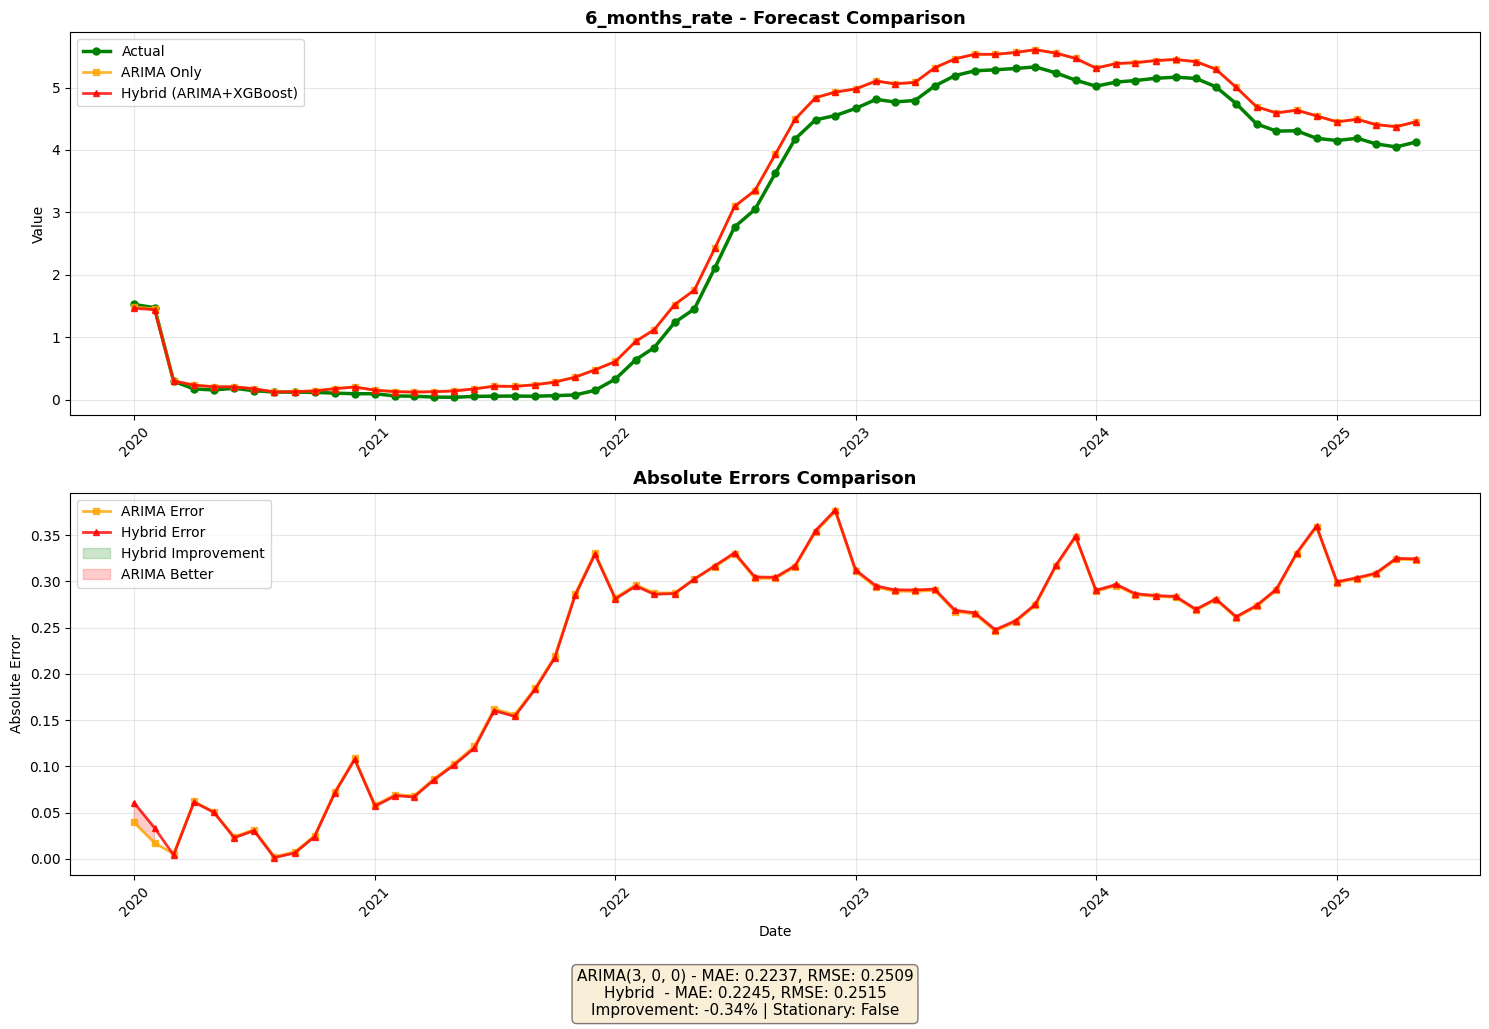


HYBRID FORECASTING: CPI
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for CPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

CPI Stationarity Test:
ADF Statistic: 0.230335
p-value: 0.973913
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 4206.77
  Trying ARIMA order: (0,0,1)
    Success: AIC = 523.69
  Trying ARIMA order: (0,0,2)
    Success: AIC = 411.94
  Trying ARIMA order: (0,0,3)
    Success: AIC = 430.73
  Trying ARIMA order: (0,1,0)
    Success: AIC = 5

[I 2025-10-12 19:03:19,207] A new study created in memory with name: no-name-88bac0d5-a987-4164-ab4d-5076b04fa162


    Success: AIC = 626.16

Best model found: ARIMA(2, 0, 3) with AIC = 358.58
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 26.3584

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 19:03:19,535] Trial 0 finished with value: 0.3158757477764597 and parameters: {'max_depth': 5, 'learning_rate': 0.04748916135447703, 'n_estimators': 80, 'subsample': 0.6220875766398313, 'colsample_bytree': 0.6622421492896691, 'reg_lambda': 2.0535349514881314, 'reg_alpha': 3.9265201574273885}. Best is trial 0 with value: 0.3158757477764597.
[I 2025-10-12 19:03:20,354] Trial 1 finished with value: 0.34649922469620253 and parameters: {'max_depth': 6, 'learning_rate': 0.08388511918426575, 'n_estimators': 260, 'subsample': 0.9757422723529363, 'colsample_bytree': 0.8177839092848288, 'reg_lambda': 2.4821686024110186, 'reg_alpha': 0.14027133670138667}. Best is trial 0 with value: 0.3158757477764597.
[I 2025-10-12 19:03:20,977] Trial 2 finished with value: 0.31150289258510505 and parameters: {'max_depth': 6, 'learning_rate': 0.1378731814686448, 'n_estimators': 234, 'subsample': 0.7729054102581032, 'colsample_bytree': 0.6320316489592529, 'reg_lambda': 1.7070468693768088, 'reg_alpha

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.03367342454855784, 'n_estimators': 235, 'subsample': 0.7228237872104163, 'colsample_bytree': 0.9954360922386627, 'reg_lambda': 0.297121017574376, 'reg_alpha': 0.2660527739650909}
XGBoost Residual MAE: 0.0362

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 26.3584, RMSE: 32.6594, MAPE: 8.62%
  Hybrid  - MAE: 26.2610, RMSE: 32.5418, MAPE: 8.59%
  Improvement: 0.37%


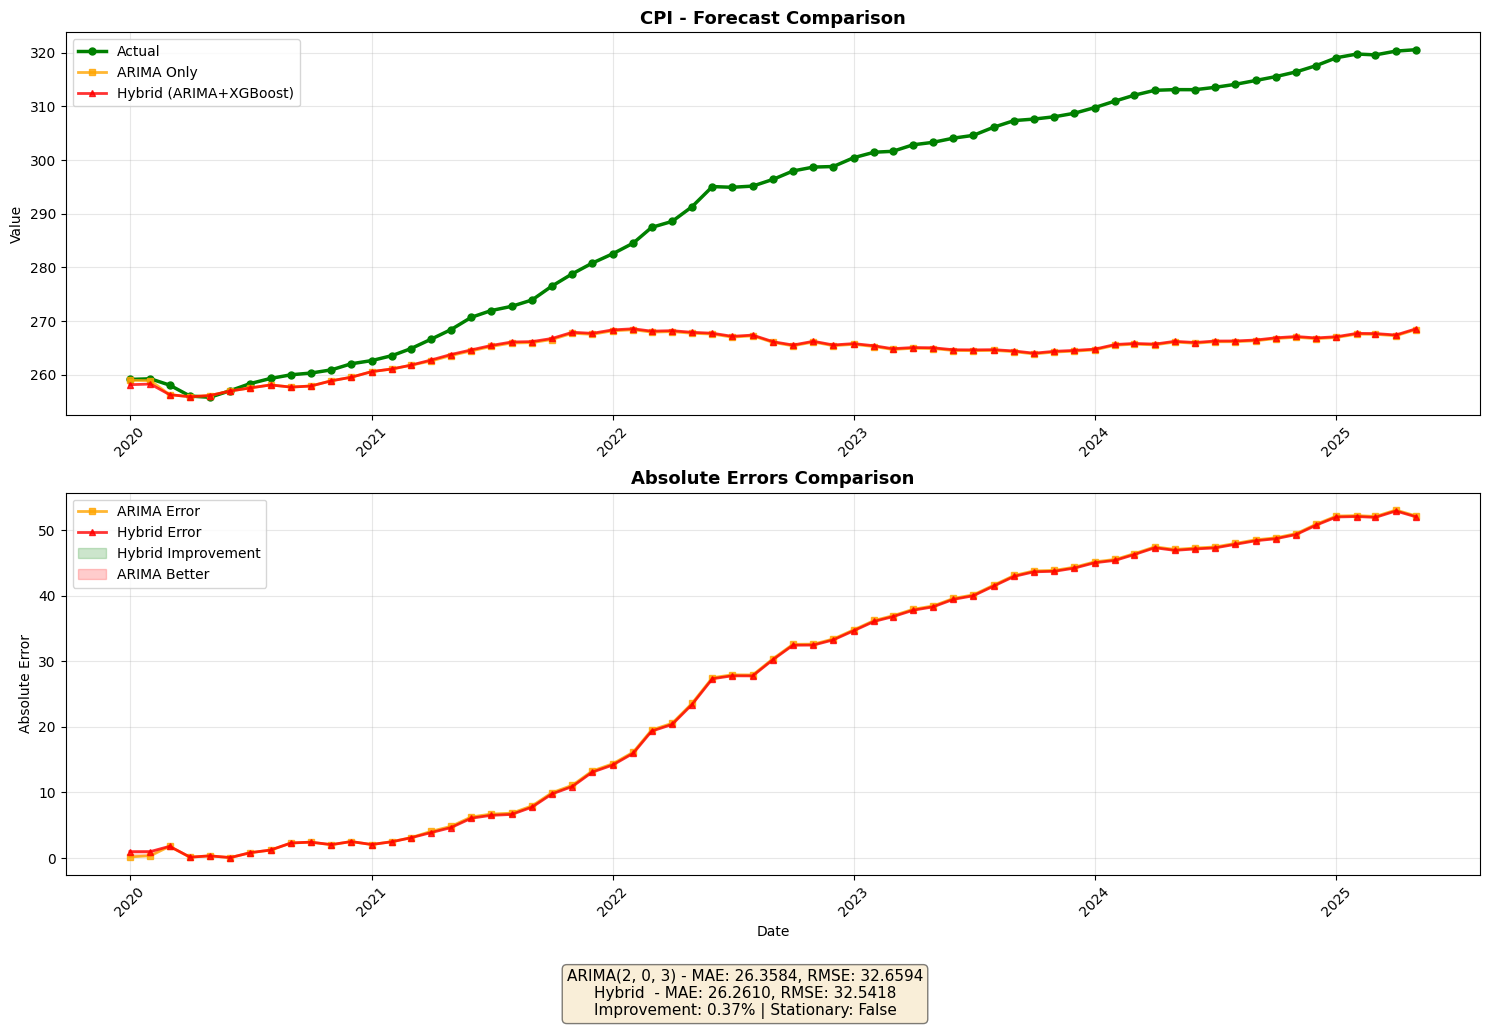


HYBRID FORECASTING: INDPRO
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for INDPRO...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

INDPRO Stationarity Test:
ADF Statistic: -0.970779
p-value: 0.763772
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 3973.30
  Trying ARIMA order: (0,0,1)
    Success: AIC = 421.58
  Trying ARIMA order: (0,0,2)
    Success: AIC = 413.09
  Trying ARIMA order: (0,0,3)
    Success: AIC = 414.16
  Trying ARIMA order: (0,1,0)
    Success: 

[I 2025-10-12 19:15:33,306] A new study created in memory with name: no-name-08109998-9391-4990-9415-fc96c0ec2a10


    Success: AIC = 695.83

Best model found: ARIMA(3, 0, 3) with AIC = 402.55
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 6.6588

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 19:15:33,507] Trial 0 finished with value: 0.2836259214150562 and parameters: {'max_depth': 3, 'learning_rate': 0.03268844670155479, 'n_estimators': 63, 'subsample': 0.8419802240871928, 'colsample_bytree': 0.7559081382498506, 'reg_lambda': 0.7442605879033799, 'reg_alpha': 0.22746413803432877}. Best is trial 0 with value: 0.2836259214150562.
[I 2025-10-12 19:15:33,899] Trial 1 finished with value: 0.18078860051761597 and parameters: {'max_depth': 3, 'learning_rate': 0.03440305714723492, 'n_estimators': 236, 'subsample': 0.9618037756211337, 'colsample_bytree': 0.8766304514935404, 'reg_lambda': 2.496916428139262, 'reg_alpha': 0.43570924100758157}. Best is trial 1 with value: 0.18078860051761597.
[I 2025-10-12 19:15:34,328] Trial 2 finished with value: 0.32429673587382385 and parameters: {'max_depth': 8, 'learning_rate': 0.22364888267838198, 'n_estimators': 163, 'subsample': 0.8044876850027942, 'colsample_bytree': 0.8034633428712963, 'reg_lambda': 0.11193749899344661, 'reg_al

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.07741203212986492, 'n_estimators': 216, 'subsample': 0.9723817041845713, 'colsample_bytree': 0.9110509205032424, 'reg_lambda': 3.253969317697953, 'reg_alpha': 0.3610193646590218}
XGBoost Residual MAE: 0.0289

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 6.6588, RMSE: 7.3761, MAPE: 6.52%
  Hybrid  - MAE: 6.6984, RMSE: 7.4067, MAPE: 6.56%
  Improvement: -0.60%


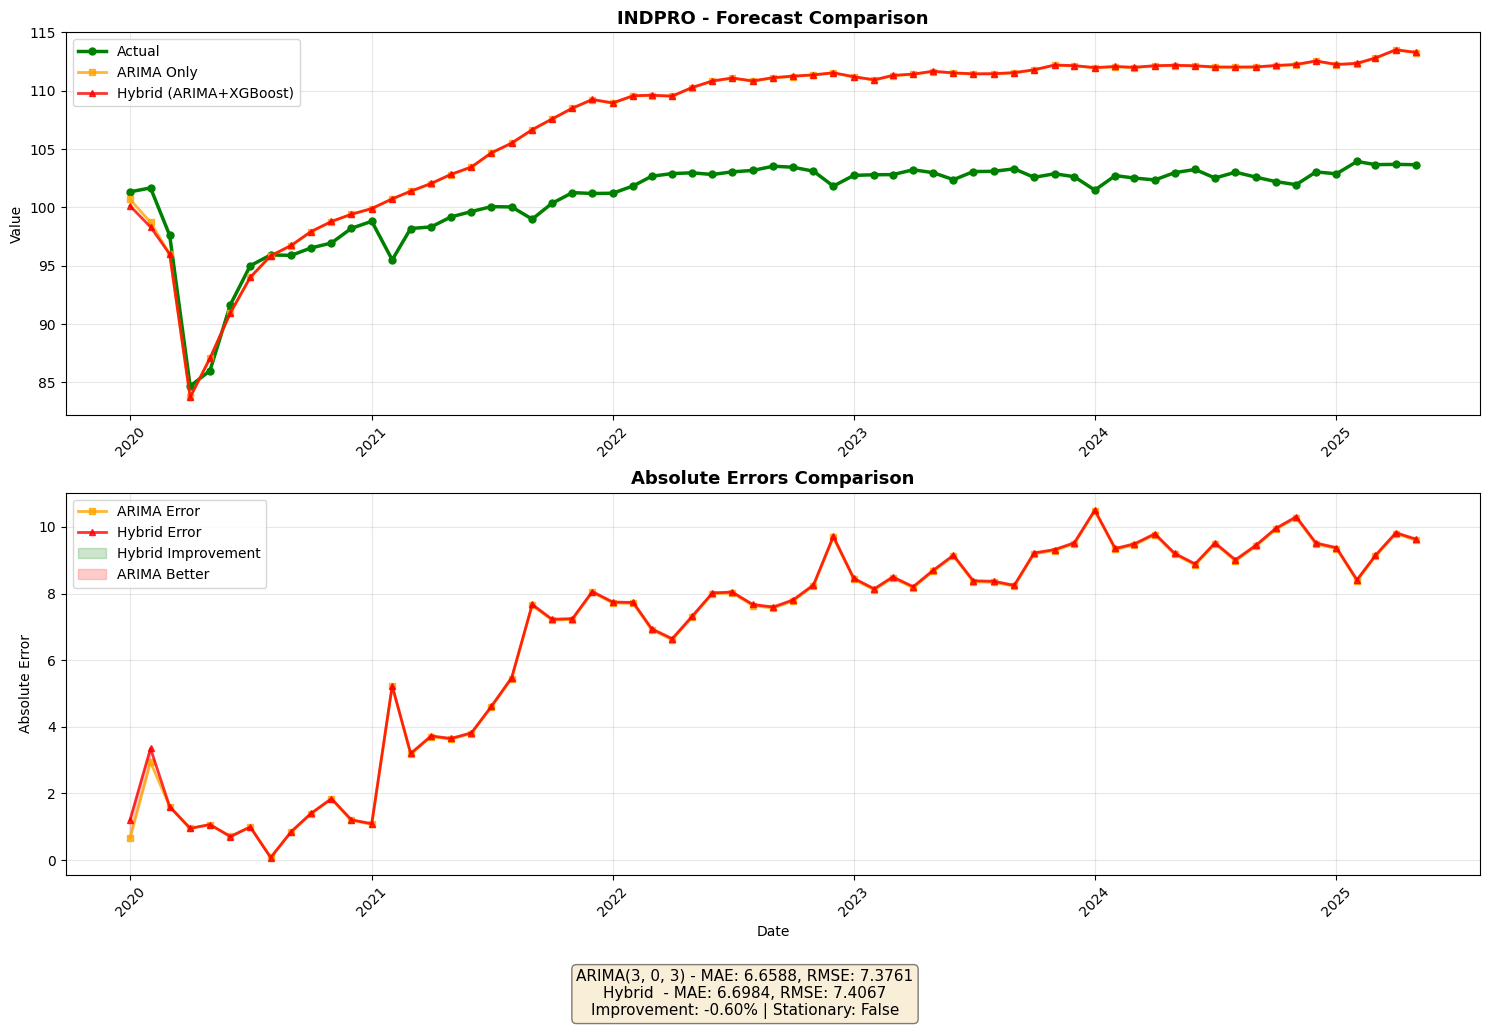


HYBRID FORECASTING: 10_year_rate
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for 10_year_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

10_year_rate Stationarity Test:
ADF Statistic: -0.897583
p-value: 0.788767
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 2045.06
  Trying ARIMA order: (0,0,1)
    Success: AIC = -1661.23
  Trying ARIMA order: (0,0,2)
    Success: AIC = -1687.43
  Trying ARIMA order: (0,0,3)
    Success: AIC = -1601.21
  Trying ARIMA order: (0,

[I 2025-10-12 19:29:38,890] A new study created in memory with name: no-name-22bf9152-a04e-4cdc-bbe5-d92d5dc00761


    Success: AIC = -1437.69

Best model found: ARIMA(2, 0, 1) with AIC = -1737.79
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 0.2144

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 19:29:39,466] Trial 0 finished with value: 0.03215163291258482 and parameters: {'max_depth': 7, 'learning_rate': 0.021739389452528627, 'n_estimators': 113, 'subsample': 0.684930980220876, 'colsample_bytree': 0.6549726584653358, 'reg_lambda': 0.48612748267182954, 'reg_alpha': 0.3117667193401131}. Best is trial 0 with value: 0.03215163291258482.
[I 2025-10-12 19:29:39,611] Trial 1 finished with value: 0.031154814494371203 and parameters: {'max_depth': 4, 'learning_rate': 0.07900481636261561, 'n_estimators': 69, 'subsample': 0.8707490317157107, 'colsample_bytree': 0.642980845297511, 'reg_lambda': 0.23439532635665444, 'reg_alpha': 1.2921742113193502}. Best is trial 1 with value: 0.031154814494371203.
[I 2025-10-12 19:29:40,207] Trial 2 finished with value: 0.026129922114918044 and parameters: {'max_depth': 5, 'learning_rate': 0.08218213070995797, 'n_estimators': 277, 'subsample': 0.8040043461484875, 'colsample_bytree': 0.6509577413008009, 'reg_lambda': 1.3632619518222886, 're

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.14446131325695108, 'n_estimators': 235, 'subsample': 0.912304606508183, 'colsample_bytree': 0.8504348254850331, 'reg_lambda': 1.2239260163526153, 'reg_alpha': 0.21022409393072652}
XGBoost Residual MAE: 0.0054

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 0.2144, RMSE: 0.2457, MAPE: 8.17%
  Hybrid  - MAE: 0.2142, RMSE: 0.2451, MAPE: 8.15%
  Improvement: 0.09%


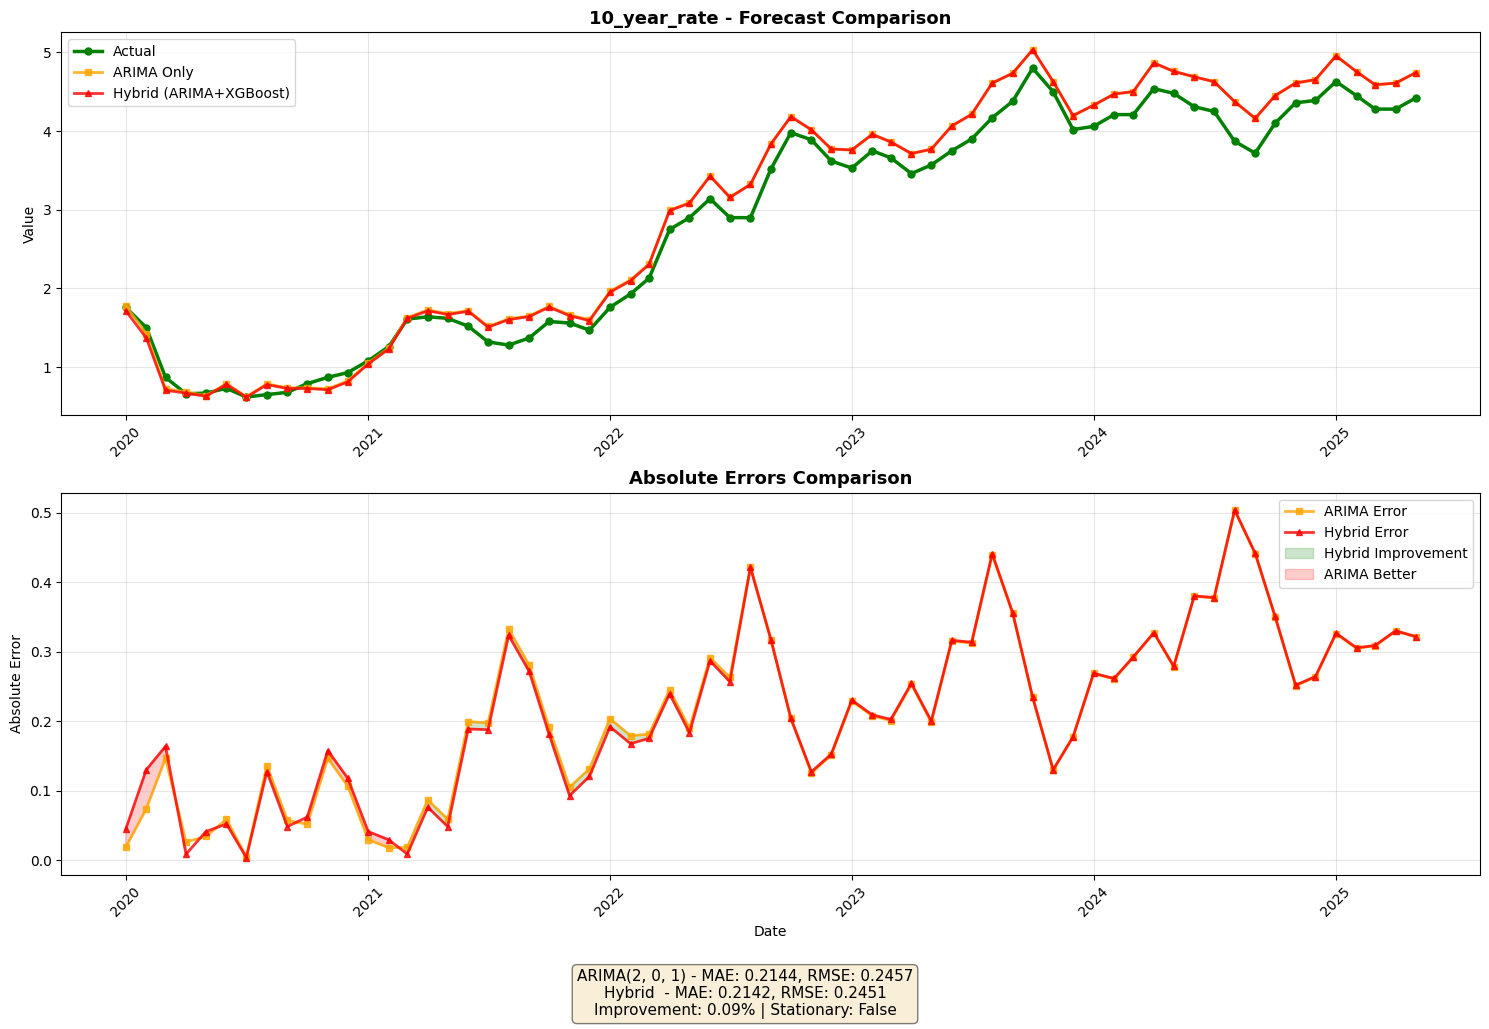


HYBRID FORECASTING: share_price
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for share_price...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

share_price Stationarity Test:
ADF Statistic: 0.695940
p-value: 0.989756
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 5853.42
  Trying ARIMA order: (0,0,1)
    Success: AIC = 2193.74
  Trying ARIMA order: (0,0,2)
    Success: AIC = 2180.16
  Trying ARIMA order: (0,0,3)
    Success: AIC = 2192.11
  Trying ARIMA order: (0,1,0)
 

[I 2025-10-12 19:39:49,352] A new study created in memory with name: no-name-42e90101-7f2b-4e6b-a192-babc1d88ec87


    Success: AIC = 2478.57

Best model found: ARIMA(2, 0, 2) with AIC = 2166.03
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 21.1931

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 19:39:49,940] Trial 0 finished with value: 1.2142337396747986 and parameters: {'max_depth': 4, 'learning_rate': 0.09053240804607895, 'n_estimators': 226, 'subsample': 0.9192739913944168, 'colsample_bytree': 0.7760659970587832, 'reg_lambda': 1.0217666957229867, 'reg_alpha': 0.13661338866407088}. Best is trial 0 with value: 1.2142337396747986.
[I 2025-10-12 19:39:50,681] Trial 1 finished with value: 1.4322934720557141 and parameters: {'max_depth': 8, 'learning_rate': 0.12425592048823043, 'n_estimators': 225, 'subsample': 0.6801783914683843, 'colsample_bytree': 0.9867690263504867, 'reg_lambda': 0.8835246267803749, 'reg_alpha': 4.112426500305877}. Best is trial 0 with value: 1.2142337396747986.
[I 2025-10-12 19:39:51,274] Trial 2 finished with value: 1.423086087247367 and parameters: {'max_depth': 5, 'learning_rate': 0.010398844152382403, 'n_estimators': 230, 'subsample': 0.6427317049826099, 'colsample_bytree': 0.8060027374557525, 'reg_lambda': 4.914823779770627, 'reg_alpha':

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.07682766746767064, 'n_estimators': 155, 'subsample': 0.7553354303569471, 'colsample_bytree': 0.8173154781318274, 'reg_lambda': 0.2230852841586569, 'reg_alpha': 2.4427426990285004}
XGBoost Residual MAE: 0.1768

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 21.1931, RMSE: 25.5255, MAPE: 14.10%
  Hybrid  - MAE: 21.3504, RMSE: 25.6616, MAPE: 14.21%
  Improvement: -0.74%


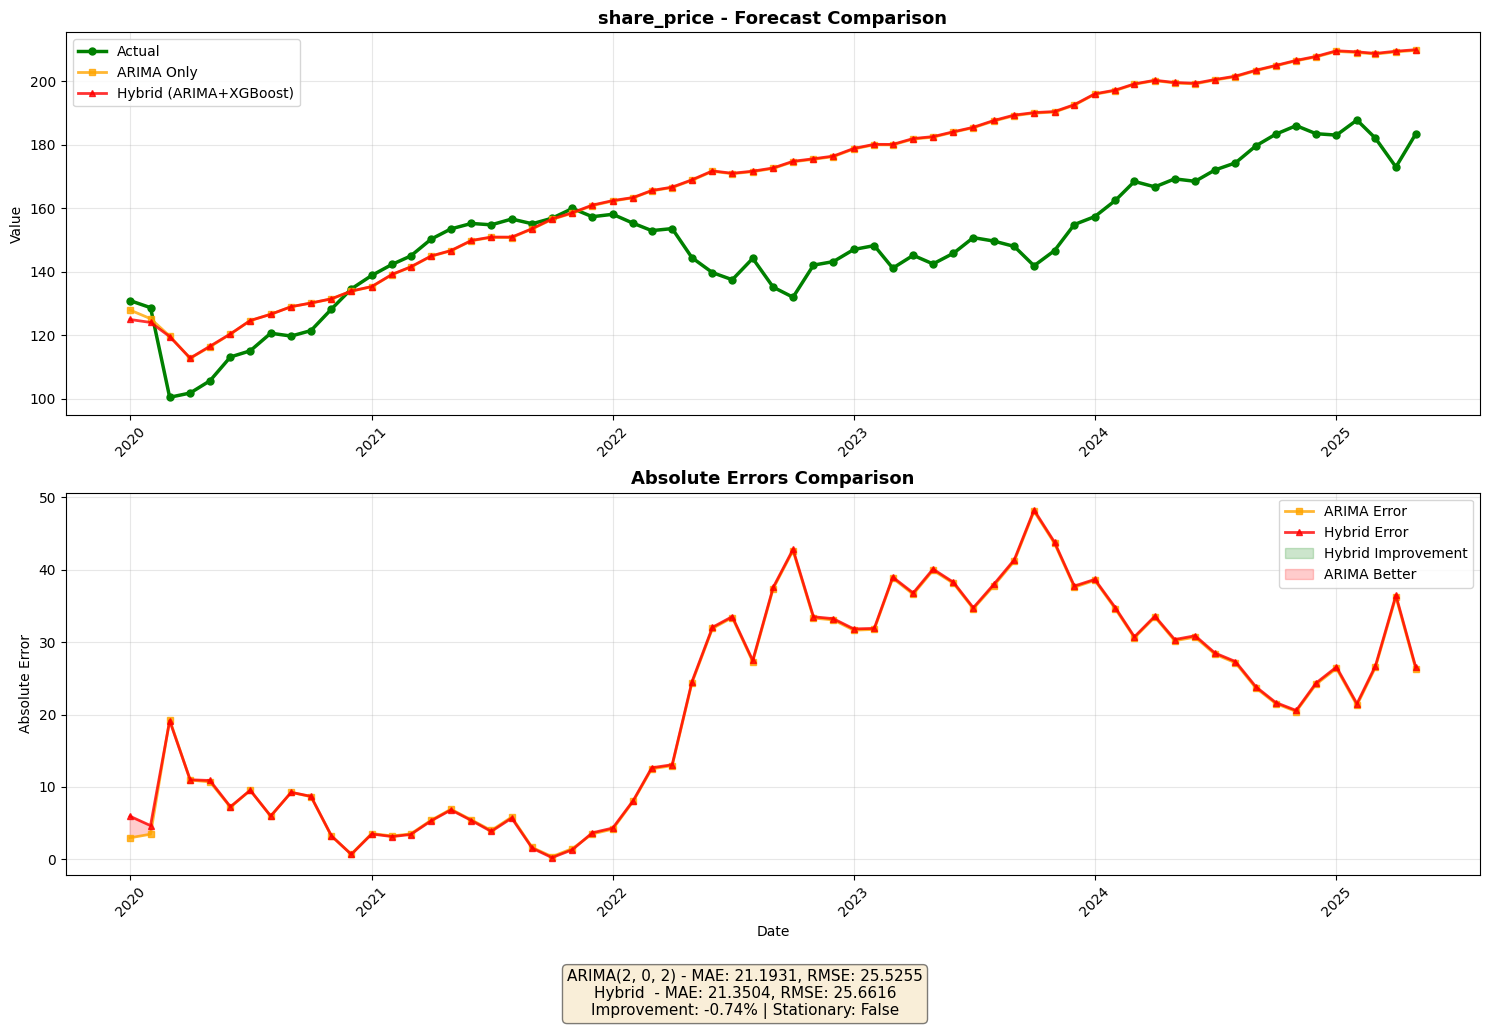


HYBRID FORECASTING: unemployment_rate
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for unemployment_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

unemployment_rate Stationarity Test:
ADF Statistic: -3.046251
p-value: 0.030795
Series is stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 2662.29
  Trying ARIMA order: (0,0,1)
    Success: AIC = -868.37
  Trying ARIMA order: (0,0,2)
    Success: AIC = -881.19
  Trying ARIMA order: (0,0,3)
    Success: AIC = -879.19
  Trying ARIMA order: 

[I 2025-10-12 19:49:06,133] A new study created in memory with name: no-name-9db535fc-61c5-4e3f-9228-8f283465ac27


    Success: AIC = -609.21

Best model found: ARIMA(1, 0, 0) with AIC = -881.93
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 1.4607

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 19:49:06,824] Trial 0 finished with value: 0.09175984459746621 and parameters: {'max_depth': 8, 'learning_rate': 0.025908626531166146, 'n_estimators': 130, 'subsample': 0.9304507913666917, 'colsample_bytree': 0.9019553211324394, 'reg_lambda': 1.202483698589636, 'reg_alpha': 2.309806509648551}. Best is trial 0 with value: 0.09175984459746621.
[I 2025-10-12 19:49:07,173] Trial 1 finished with value: 0.07508578066304014 and parameters: {'max_depth': 7, 'learning_rate': 0.14208205784870323, 'n_estimators': 188, 'subsample': 0.9327993308679364, 'colsample_bytree': 0.8299257277726084, 'reg_lambda': 0.2089236847554626, 'reg_alpha': 1.4109174055344065}. Best is trial 1 with value: 0.07508578066304014.
[I 2025-10-12 19:49:07,838] Trial 2 finished with value: 0.07669239344231894 and parameters: {'max_depth': 7, 'learning_rate': 0.06584067957097771, 'n_estimators': 222, 'subsample': 0.8969474904548214, 'colsample_bytree': 0.6611874419252854, 'reg_lambda': 4.515627422179375, 'reg_alp

Best XGBoost params: {'max_depth': 4, 'learning_rate': 0.14113463885004432, 'n_estimators': 211, 'subsample': 0.749389966625128, 'colsample_bytree': 0.8669525315779336, 'reg_lambda': 1.4897625413934268, 'reg_alpha': 0.6061410400267323}
XGBoost Residual MAE: 0.0143

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 1.4607, RMSE: 2.2078, MAPE: 24.88%
  Hybrid  - MAE: 1.4752, RMSE: 2.2177, MAPE: 25.21%
  Improvement: -0.99%


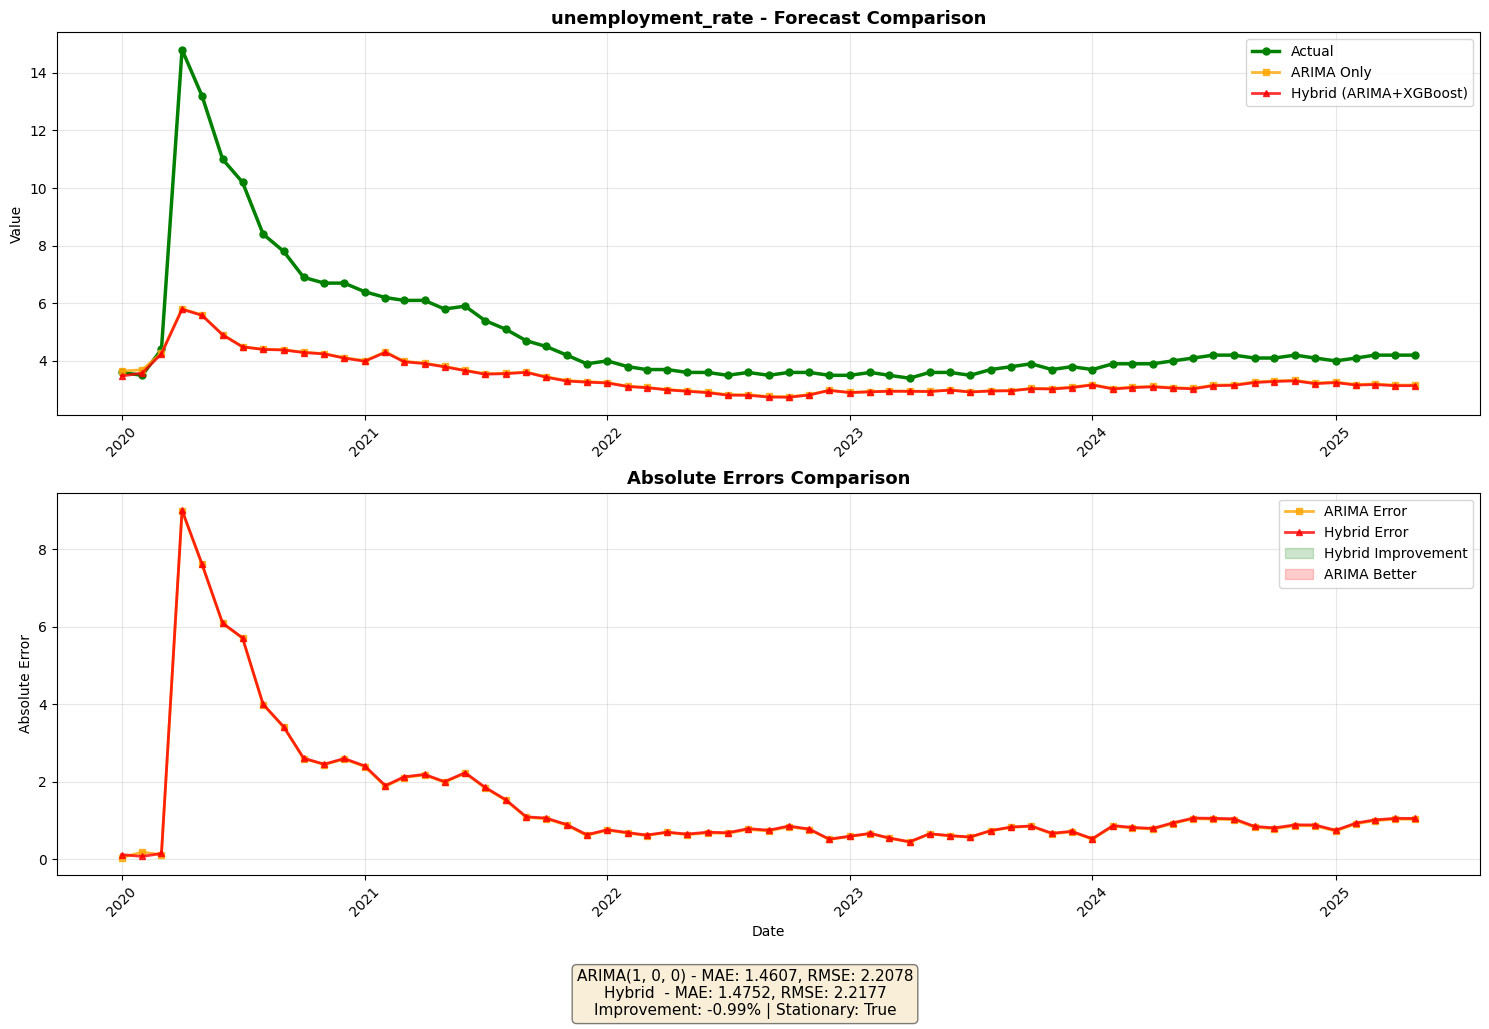


HYBRID FORECASTING: PPI
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for PPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'OECD_CLI_index', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

PPI Stationarity Test:
ADF Statistic: 0.191008
p-value: 0.971753
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 7246.29
  Trying ARIMA order: (0,0,1)
    Success: AIC = 3837.48
  Trying ARIMA order: (0,0,2)
    Success: AIC = 3422.84
  Trying ARIMA order: (0,0,3)
    Success: AIC = 3125.97
  Trying ARIMA order: (0,1,0)
    Success: AIC 

[I 2025-10-12 20:00:51,612] A new study created in memory with name: no-name-6a27e1fb-6872-4c77-aeff-c660e3500cec


    Success: AIC = 3036.83

Best model found: ARIMA(3, 1, 1) with AIC = 2947.58
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 135.6728

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 20:00:52,261] Trial 0 finished with value: 3.3888907211952595 and parameters: {'max_depth': 5, 'learning_rate': 0.2622223720009607, 'n_estimators': 259, 'subsample': 0.6047180674271166, 'colsample_bytree': 0.895952187206061, 'reg_lambda': 1.2614070461361508, 'reg_alpha': 2.7259810172382264}. Best is trial 0 with value: 3.3888907211952595.
[I 2025-10-12 20:00:52,763] Trial 1 finished with value: 3.9593500214811606 and parameters: {'max_depth': 4, 'learning_rate': 0.03427471033810943, 'n_estimators': 246, 'subsample': 0.9388143497486345, 'colsample_bytree': 0.9934607024686122, 'reg_lambda': 2.2977379270190035, 'reg_alpha': 1.0932260220622627}. Best is trial 0 with value: 3.3888907211952595.
[I 2025-10-12 20:00:53,241] Trial 2 finished with value: 3.651338848814183 and parameters: {'max_depth': 4, 'learning_rate': 0.14674388051301415, 'n_estimators': 285, 'subsample': 0.8652795125311846, 'colsample_bytree': 0.7161496541745903, 'reg_lambda': 1.1401924765610794, 'reg_alpha': 2

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.09172739782687472, 'n_estimators': 291, 'subsample': 0.6047903325050153, 'colsample_bytree': 0.8566285448015077, 'reg_lambda': 0.44770400472727995, 'reg_alpha': 3.836041318911294}
XGBoost Residual MAE: 0.1853

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 135.6728, RMSE: 162.9938, MAPE: 25.45%
  Hybrid  - MAE: 136.3980, RMSE: 163.4419, MAPE: 25.62%
  Improvement: -0.53%


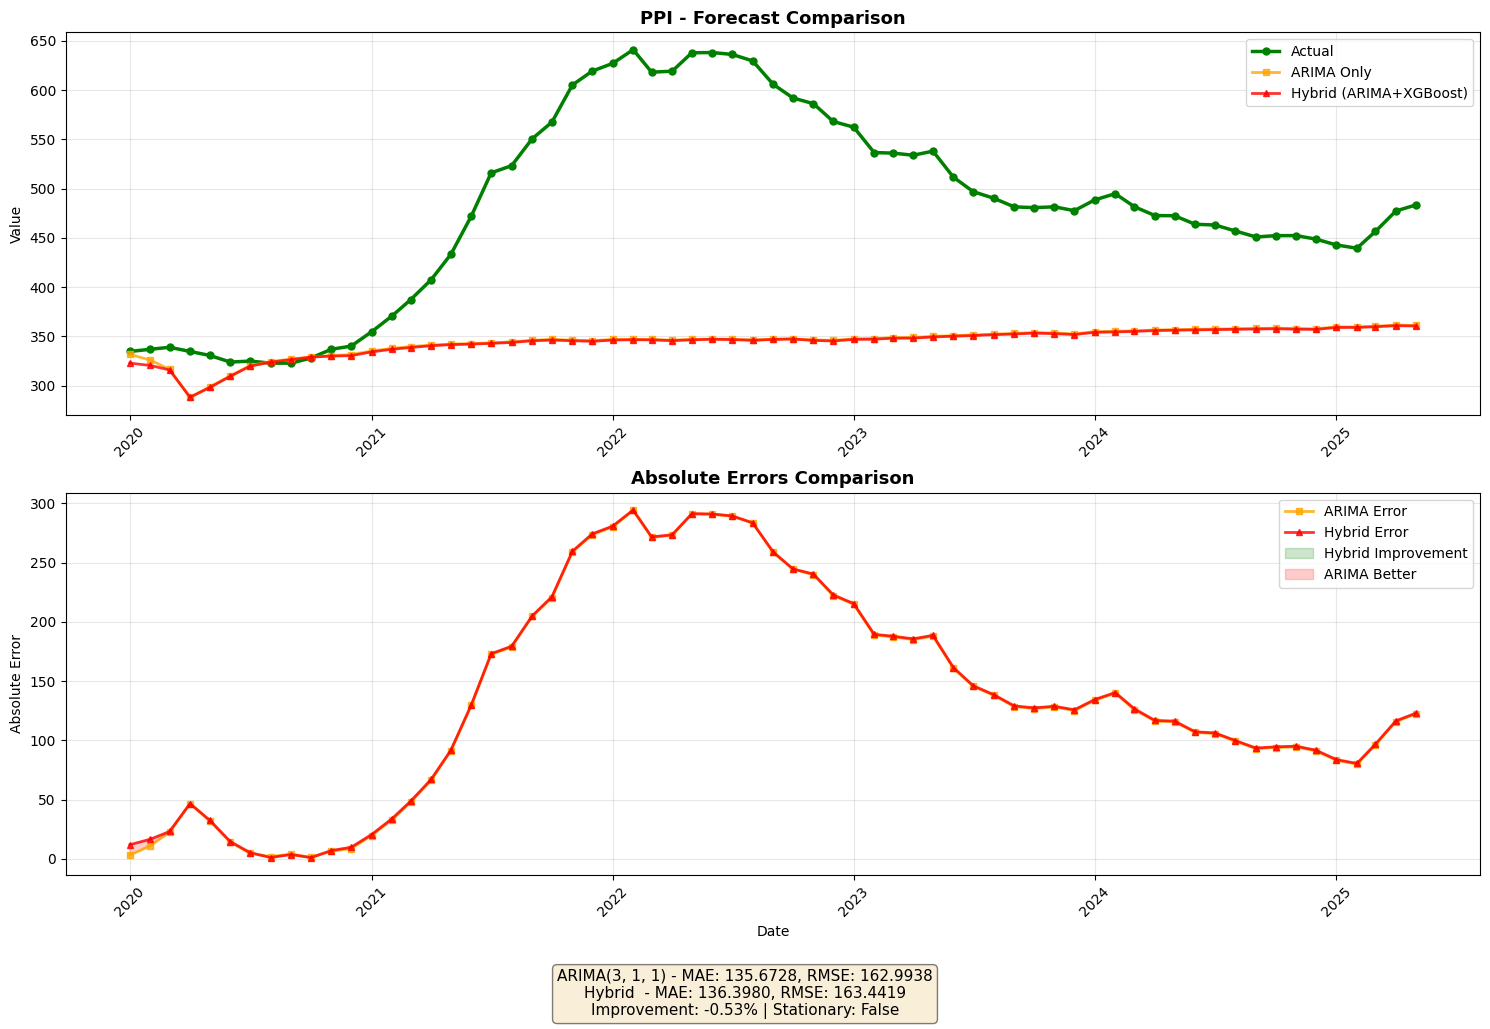


HYBRID FORECASTING: OECD_CLI_index
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for OECD_CLI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'CSI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

OECD_CLI_index Stationarity Test:
ADF Statistic: -6.053841
p-value: 0.000000
Series is stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 1724.06
  Trying ARIMA order: (0,0,1)
    Success: AIC = -1689.18
  Trying ARIMA order: (0,0,2)
    Success: AIC = -2236.87
  Trying ARIMA order: (0,0,3)
    Success: AIC = -2164.63
  Trying ARIMA order: (0,

[I 2025-10-12 20:11:52,247] A new study created in memory with name: no-name-8661980e-b654-4073-ab37-3c840e873a0c


    Success: AIC = -2901.00

Best model found: ARIMA(3, 2, 0) with AIC = -3263.55
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 1.3914

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 20:11:53,009] Trial 0 finished with value: 0.014526030326937785 and parameters: {'max_depth': 6, 'learning_rate': 0.015922223143077625, 'n_estimators': 240, 'subsample': 0.6232621006968029, 'colsample_bytree': 0.6559587701172879, 'reg_lambda': 3.177032905546362, 'reg_alpha': 0.3489139667552202}. Best is trial 0 with value: 0.014526030326937785.
[I 2025-10-12 20:11:53,168] Trial 1 finished with value: 0.015272707044804521 and parameters: {'max_depth': 7, 'learning_rate': 0.14995397657027237, 'n_estimators': 133, 'subsample': 0.7177924441562855, 'colsample_bytree': 0.6102978803455964, 'reg_lambda': 4.7670864080001465, 'reg_alpha': 1.0577590227602798}. Best is trial 0 with value: 0.014526030326937785.
[I 2025-10-12 20:11:53,607] Trial 2 finished with value: 0.014992572008231906 and parameters: {'max_depth': 8, 'learning_rate': 0.01761347596137846, 'n_estimators': 138, 'subsample': 0.6507642448815573, 'colsample_bytree': 0.7431885067837929, 'reg_lambda': 0.25846242227863203, 

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.2719074144455954, 'n_estimators': 61, 'subsample': 0.8755640351987795, 'colsample_bytree': 0.8498196352709673, 'reg_lambda': 0.1139951794379162, 'reg_alpha': 0.11445874284074024}
XGBoost Residual MAE: 0.0030

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 1.3914, RMSE: 1.6184, MAPE: 1.40%
  Hybrid  - MAE: 1.3877, RMSE: 1.6155, MAPE: 1.39%
  Improvement: 0.27%


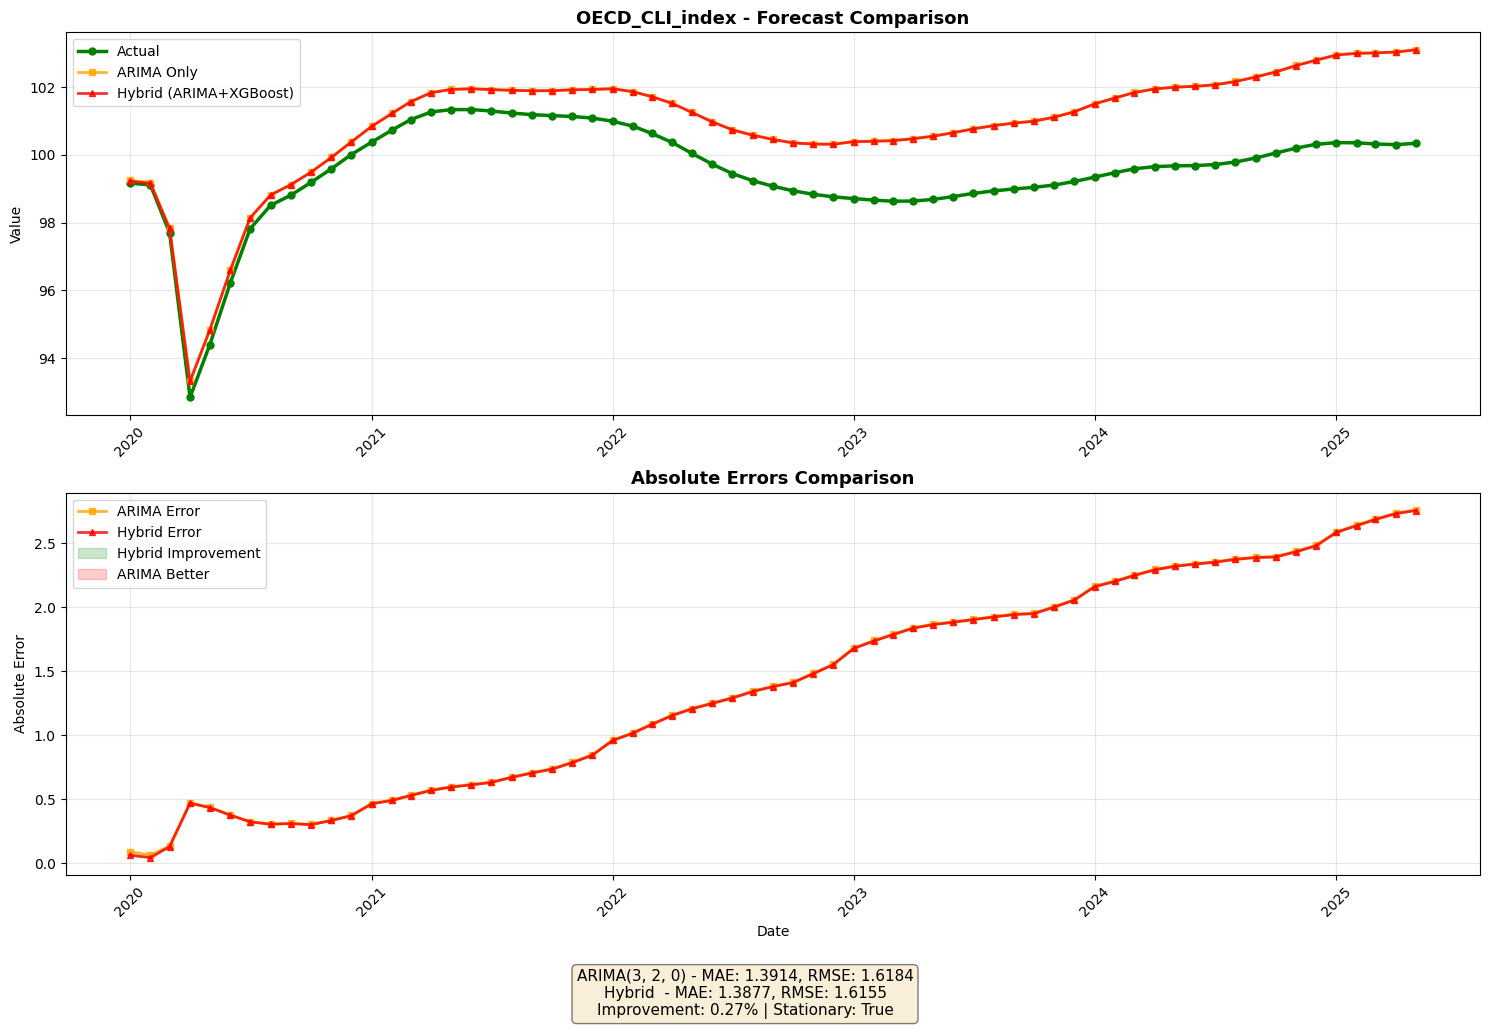


HYBRID FORECASTING: CSI_index
Series lengths - Train: 635, Test: 65

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for CSI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

CSI_index Stationarity Test:
ADF Statistic: -3.389553
p-value: 0.011320
Series is stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 6749.28
  Trying ARIMA order: (0,0,1)
    Success: AIC = 3186.75
  Trying ARIMA order: (0,0,2)
    Success: AIC = 3194.35
  Trying ARIMA order: (0,0,3)
    Success: AIC = 3176.60
  Trying ARIMA order: (0,1,0)
    Succ

[I 2025-10-12 20:22:50,917] A new study created in memory with name: no-name-d8c9b1c7-09f5-420c-826d-57cf680503a3


    Success: AIC = 3545.49

Best model found: ARIMA(2, 0, 2) with AIC = 3122.50
Total successful fits: 48
  Forecasting 65 steps ahead
ARIMA MAE: 34.5172

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 20:22:51,288] Trial 0 finished with value: 1.0129671450961761 and parameters: {'max_depth': 3, 'learning_rate': 0.06803628804459337, 'n_estimators': 149, 'subsample': 0.8673268983820419, 'colsample_bytree': 0.8837888975177162, 'reg_lambda': 1.2940386922024611, 'reg_alpha': 0.1075061730959964}. Best is trial 0 with value: 1.0129671450961761.
[I 2025-10-12 20:22:51,455] Trial 1 finished with value: 1.4410172634984162 and parameters: {'max_depth': 3, 'learning_rate': 0.07811618106840298, 'n_estimators': 114, 'subsample': 0.7768320589449639, 'colsample_bytree': 0.6546416000812113, 'reg_lambda': 1.438697122067554, 'reg_alpha': 0.20156214604515343}. Best is trial 0 with value: 1.0129671450961761.
[I 2025-10-12 20:22:51,729] Trial 2 finished with value: 1.8540011316499454 and parameters: {'max_depth': 4, 'learning_rate': 0.011797840253021764, 'n_estimators': 133, 'subsample': 0.9053594968230522, 'colsample_bytree': 0.7839394516397701, 'reg_lambda': 1.001470391641445, 'reg_alpha'

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.06803628804459337, 'n_estimators': 149, 'subsample': 0.8673268983820419, 'colsample_bytree': 0.8837888975177162, 'reg_lambda': 1.2940386922024611, 'reg_alpha': 0.1075061730959964}
XGBoost Residual MAE: 0.3322

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 34.5172, RMSE: 42.6003, MAPE: 51.61%
  Hybrid  - MAE: 34.6104, RMSE: 42.5532, MAPE: 51.68%
  Improvement: -0.27%


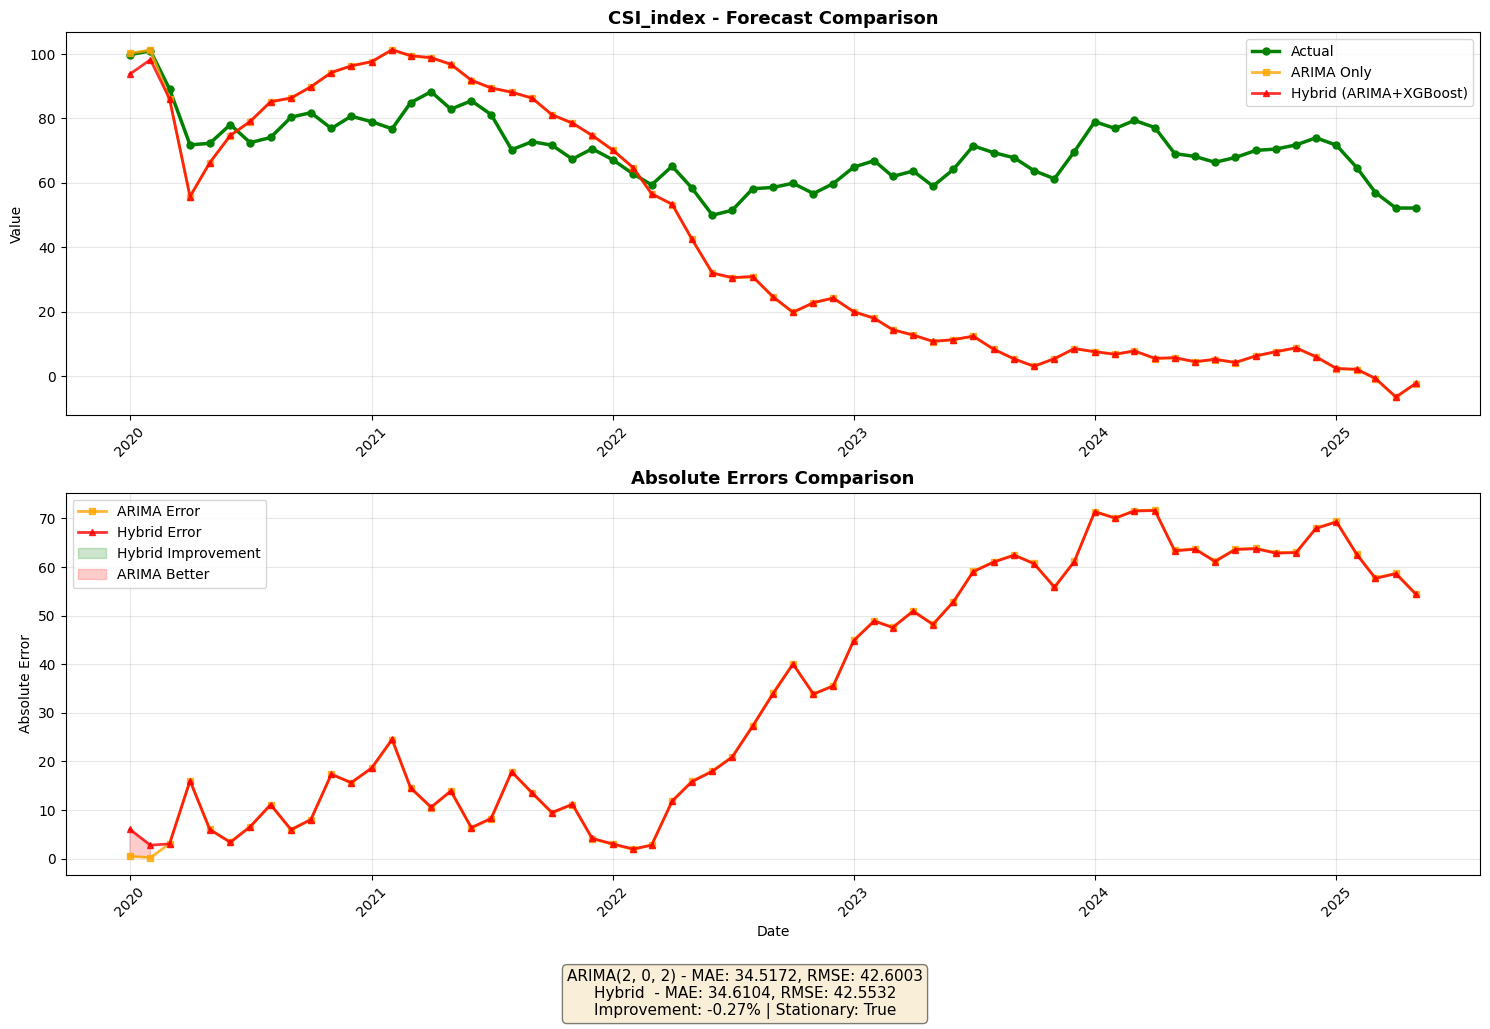


HYBRID FORECASTING: gdp_per_capita
Series lengths - Train: 635, Test: 64

--- STEP 1: Preparing Exogenous Variables ---

Preparing exogenous variables for gdp_per_capita...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning exogenous data...
  Initial shapes - Train: (635, 29), Test: (64, 29)
  Final shapes - Train: (635, 29), Test: (64, 29)
  Remaining missing values - Train: 0, Test: 0

--- STEP 2: Training ARIMA Model ---

gdp_per_capita Stationarity Test:
ADF Statistic: -0.060547
p-value: 0.953229
Series is non-stationary

Running ARIMA grid search...
Series length: 635, Exog shape: (635, 29)
  Trying ARIMA order: (0,0,0)
    Success: AIC = 9885.53
  Trying ARIMA order: (0,0,1)
    Success: AIC = 6077.95
  Trying ARIMA order: (0,0,2)
    Success: AIC = 5939.37
  Trying ARIMA order: (0,0,3)
    Success: AIC = 6040.74
  Trying ARIMA orde

[I 2025-10-12 20:34:58,019] A new study created in memory with name: no-name-63369a80-fe46-471c-b37b-6ddc303214ba


    Success: AIC = 5799.82

Best model found: ARIMA(3, 1, 3) with AIC = 5721.60
Total successful fits: 48
  Forecasting 64 steps ahead
ARIMA MAE: 168.4023

--- STEP 3: Training XGBoost on Residuals ---
Tuning XGBoost with 20 trials...


[I 2025-10-12 20:34:58,894] Trial 0 finished with value: 27.59695005917974 and parameters: {'max_depth': 6, 'learning_rate': 0.0127646335360343, 'n_estimators': 220, 'subsample': 0.6430751759571333, 'colsample_bytree': 0.8832038744139448, 'reg_lambda': 1.5646646474616435, 'reg_alpha': 0.378671405051666}. Best is trial 0 with value: 27.59695005917974.
[I 2025-10-12 20:34:59,584] Trial 1 finished with value: 26.39387889551338 and parameters: {'max_depth': 5, 'learning_rate': 0.015411641553753552, 'n_estimators': 266, 'subsample': 0.8646456428044358, 'colsample_bytree': 0.9769096248650172, 'reg_lambda': 0.9688140941846249, 'reg_alpha': 1.2475126412085629}. Best is trial 1 with value: 26.39387889551338.
[I 2025-10-12 20:34:59,926] Trial 2 finished with value: 24.89340575609967 and parameters: {'max_depth': 3, 'learning_rate': 0.1664092191917335, 'n_estimators': 233, 'subsample': 0.8781288580879614, 'colsample_bytree': 0.9732586343621428, 'reg_lambda': 2.549265565556432, 'reg_alpha': 0.7969

Best XGBoost params: {'max_depth': 3, 'learning_rate': 0.11020384634518493, 'n_estimators': 240, 'subsample': 0.9986495435076734, 'colsample_bytree': 0.7705515952445858, 'reg_lambda': 0.31301521568647245, 'reg_alpha': 0.40985302245800703}
XGBoost Residual MAE: 0.8464

--- STEP 4: Making Hybrid Predictions ---

Test Metrics:
  ARIMA   - MAE: 168.4023, RMSE: 197.4592, MAPE: 0.25%
  Hybrid  - MAE: 174.2766, RMSE: 205.1352, MAPE: 0.26%
  Improvement: -3.49%


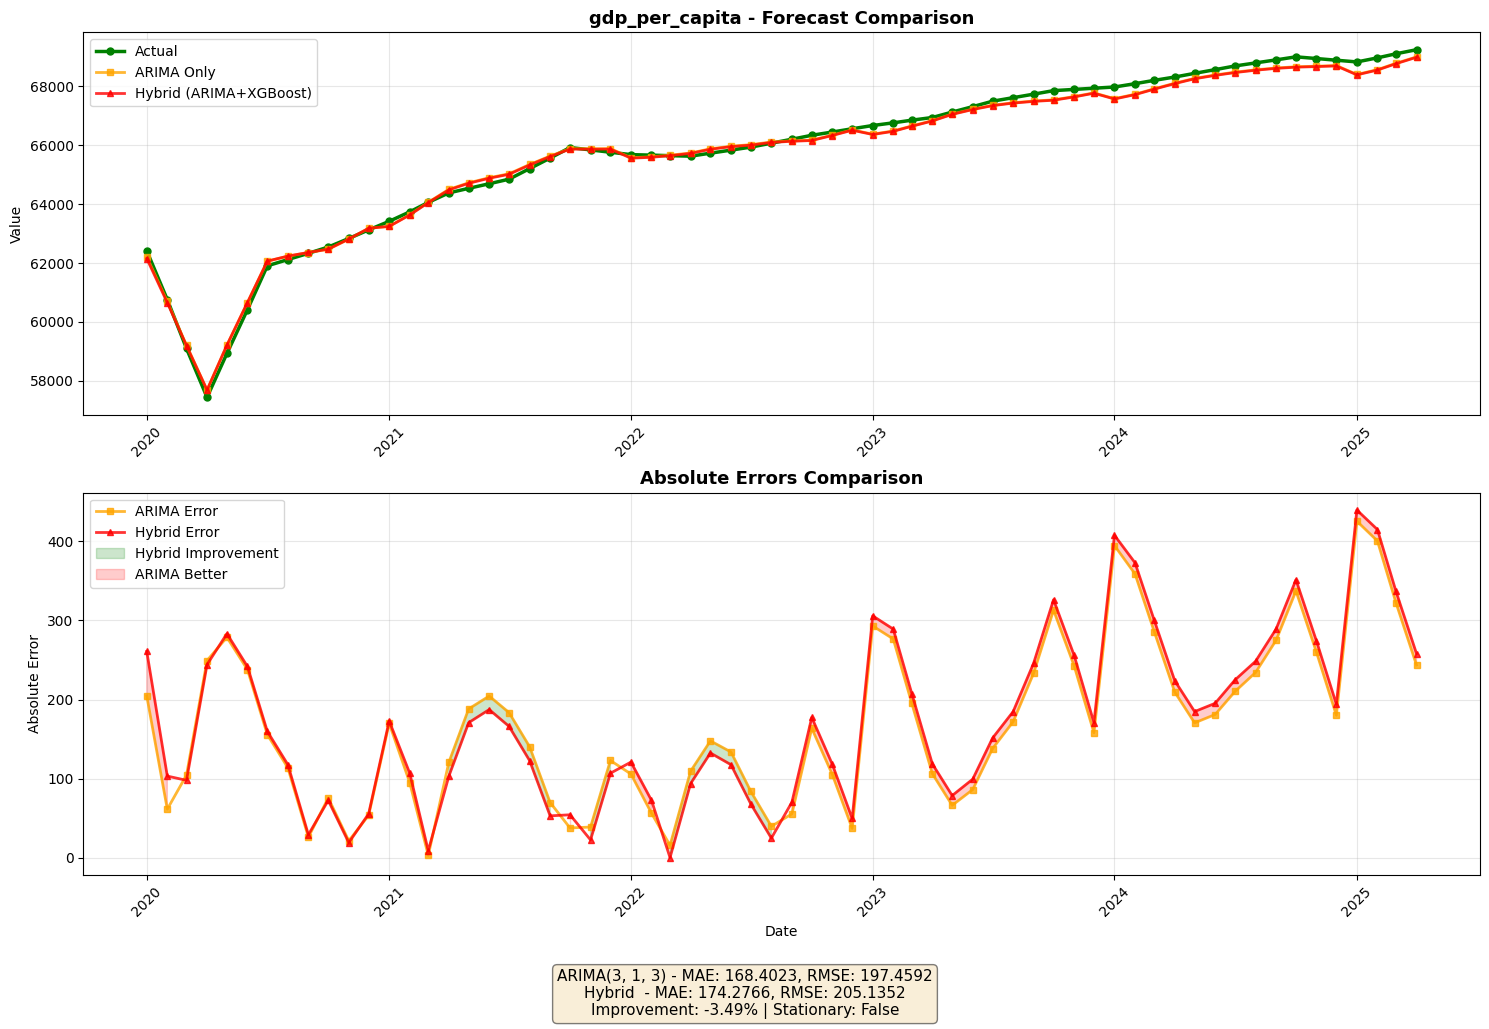


HYBRID ARIMA FORECASTING COMPLETE
Successfully forecasted 12 indicators

SUMMARY METRICS:
Indicator            ARIMA Order     ARIMA MAE    Hybrid MAE   Improvement  XGBoost Used
-----------------------------------------------------------------------------------
1_year_rate          (3, 0, 0)       0.2412       0.2383       1.22        % Yes         
3_months_rate        (3, 0, 0)       0.3939       0.3925       0.34        % Yes         
6_months_rate        (3, 0, 0)       0.2237       0.2245       -0.34       % Yes         
CPI                  (2, 0, 3)       26.3584      26.2610      0.37        % Yes         
INDPRO               (3, 0, 3)       6.6588       6.6984       -0.60       % Yes         
10_year_rate         (2, 0, 1)       0.2144       0.2142       0.09        % Yes         
share_price          (2, 0, 2)       21.1931      21.3504      -0.74       % Yes         
unemployment_rate    (1, 0, 0)       1.4607       1.4752       -0.99       % Yes         
PPI             

In [2]:
train_df = pd.read_csv('../data/fix/feature_selected_recession_train.csv')
test_df = pd.read_csv('../data/fix/feature_selected_recession_test.csv')

all_results, forecasted = run_hybrid_arima_forecasting(
    train_df, test_df, 
    financial_indicators=financial_indicators,
    max_p=3,      # Max AR order
    max_d=2,      # Max differencing
    max_q=3,      # Max MA order
    n_trials_xgb=20,
    plot_results=True
)

In [3]:
train_df.columns

Index(['date', 'recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'gdp_per_capita', 'CSI_index_trend',
       '10_year_rate_trend', '3_months_rate_trend', '1_year_rate_trend',
       'unemployment_rate_trend', '6_months_rate_trend', 'PPI_trend',
       'CPI_trend', 'gdp_per_capita_trend', 'gdp_per_capita_residual',
       'OECD_CLI_index_trend', 'OECD_CLI_index_residual',
       '3_months_rate_residual', 'INDPRO_trend', 'share_price_trend',
       '6_months_rate_residual', '1_year_rate_residual',
       '10_year_rate_residual'],
      dtype='object')